In [0]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split

from keras.models import model_from_json

import os
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

sys.path.append('..')

In [140]:
data  = pd.read_csv('daily_csv.csv')             # read CSV file
euro_data = data.loc[data['Country'] == 'Euro']

for i, row in euro_data.iterrows():
        value = euro_data.at[i,'Value']
        value_string = str(value)
        if(not value>0):
            euro_data.at[i,'Value'] = euro_data.at[i-1,'Value']


# setting index as date
df = euro_data
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


"\n# plot\nplt.figure(figsize=(16,8))\nplt.plot(df['Value'], label='Price history')\n"

In [141]:
# 
euro_data.index = euro_data.Date
euro_data.drop('Date', axis=1, inplace=True)
euro_data.drop('Country', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train, valid = train_test_split(euro_data, test_size=0.1, shuffle=False)

In [0]:
number_of_predicted_days = 30

In [0]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train.values)

In [0]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [26]:

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 1012s - loss: 7.0037e-04


In [0]:
#predicting testing data values, using past 60 from the train data
inputs = euro_data[len(euro_data) - 14 - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

predicted_price_list = []
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
    

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [0]:
input_data = scaled_data.flatten().tolist()[-60:]
input_data_as_np = np.asarray(input_data).reshape((1, len(input_data), 1))

predictions = []
for i in range(number_of_predicted_days):
  prediction = model.predict(input_data_as_np)
  predictions.append(prediction[0, 0])
  
  updated_input = input_data_as_np.flatten().tolist()
  updated_input.append(prediction[0, 0])
  updated_input.pop(0)
  
  input_data_as_np = np.asarray(updated_input).reshape((1, len(updated_input), 1))

In [0]:
predictionsnp = scaler.inverse_transform(np.asarray(predictions).reshape((len(predictions), 1)))
a = predictionsnp.flatten().tolist()

In [179]:
validation = valid['Value'].tolist()[:number_of_predicted_days]

[0.9228,
 0.9206,
 0.9206,
 0.9121,
 0.9121,
 0.9169,
 0.9168,
 0.9231,
 0.9247,
 0.9232,
 0.922,
 0.9202,
 0.9131,
 0.9232,
 0.9184,
 0.9168,
 0.9049,
 0.8929,
 0.8984,
 0.8953,
 0.885,
 0.8911,
 0.8801,
 0.8901,
 0.8901,
 0.8977,
 0.8977,
 0.9016,
 0.8987,
 0.9076]

In [0]:
# create new training and testing DataFrames for plotting

# validation
validationnp = np.asarray(validation)
validation_df = pd.DataFrame(validationnp)
validation_df.index=valid.index[:number_of_predicted_days]
validation_df.columns = ['Value']

# training
training = np.asarray(train[-60:])
training_df = pd.DataFrame(training)
training_df.columns = ['Value']
training_df.index=train.index[-60:]


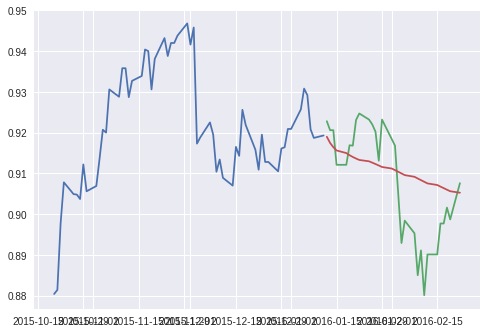

In [181]:
plt.plot(training_df['Value'])
plt.plot(validation_df['Value'])
validation_df['Predictions'] = a
plt.plot(validation_df['Predictions'])

In [175]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
'''
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split

from keras.models import model_from_json

import os
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

sys.path.append('..')
'''

def predict_rate(rate_for_past_sixty_days, number_of_predicted_days = 14):
  # load trained LSTM
  json_file = open('model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  
  # load weights into new model
  model.load_weights("model.h5")
  print("Loaded model from disk")
  
  # scale data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(rate_for_past_sixty_days.values)
  
  # make prediction
  input_data = scaled_data.flatten().tolist()[-60:]
  input_data_as_np = np.asarray(input_data).reshape((1, len(input_data), 1))

  predictions = []
  for i in range(number_of_predicted_days):
    prediction = model.predict(input_data_as_np)
    predictions.append(prediction[0, 0])

    updated_input = input_data_as_np.flatten().tolist()
    updated_input.append(prediction[0, 0])
    updated_input.pop(0)

    input_data_as_np = np.asarray(updated_input).reshape((1, len(updated_input), 1))
    
    predictionsnp = scaler.inverse_transform(np.asarray(predictions).reshape((len(predictions), 1)))
    a = predictionsnp.flatten().tolist()
    
  print('List of predictions:')
  print(a)
  

In [186]:
predict_rate(rate_for_past_sixty_days=train)

Loaded model from disk
Predictions
[0.9189808368682861, 0.9174799919128418, 0.9164280891418457, 0.9156232476234436, 0.9149823188781738, 0.9144595861434937, 0.9140213131904602, 0.9136396646499634, 0.9132914543151855, 0.9129580855369568, 0.9126260876655579, 0.9122864603996277, 0.9119341373443604, 0.9115673303604126]
